# Trash bin project

Any city in the world has trash-bins, which fill up over time. Each of the trash bins needs to be emptied from time to time.   
Each workforce in a city work on a certain schedule and therefore on predefined routes to empty trash-bins. The assumption is, that a route always   
follows the same pattern. A person of the workforce will start it's route and approach trash-bins, which have a filling level of 10%, 20% etc.   
Some of the trash-bins are approached and are almost empty. In order to reduce the effort resp. time consumption an optimization should be considered.  

The project idea at hand is to equip each and every trash-bin with an IoT component, which communicates with a central server. The IoT compnent  
should be able to send a timestamp, location- and filling information (e.g. 10, 20, ..., 100%) etc., but also hardware status information about the   
component itself. 

The received information must be processed via big data. A threshold needs to be defined (filling level e.g. 50%), where a trash-bin needs attention.   
The appliaction should monitor the filling levels and propose an optimale route (leeds to an optimization) based on the `travelling salesman problem`.   
A simulated annealing optimization algorithm or an OR - Tools approach should be used to resolve the optimal route of a Garbageman.   






## Context Diagram 
The context diagram shows the main building blocks of the application at hand.

<img src="images/Context_1.jpg" alt="Context Diagram" width="800">

## Scope

- Simulated data (JSON) for Switzerland and Winterthur (any number of trash bin's is ok, but 26 have been used for each)
- Considere filling level of trash-bins and HW maintenance in optimal route
- Optimal Route via Travelling salesman problem 
- Visualization in gmaps with markers and optimal route
- TCP Streaming consumer/producer for Data Analytics
- TCP Client/Server for Route Analytics

Out of scope  
- Historic data 
- Predictive failure detection of HW Module


## Key Performance Indicator (KPI)

- None of the trash bins should be full (consider filling level > 50%)
- hardware failure should also be considered in a route



## Building Blocks of IoT Device Hardware

In many IoT products, the “thing” is fully integrated into the smart device. For example, think of products like an autonomous trash bin. These products control and monitor themselves. In this case, your product includes all four building blocks in a single package as shown below.

<img src="images/iot_building_blocks.jpg" alt="Building Blocks" width="500">


#### Building Block 1: Thing
I define “thing” as the asset that you want to control or monitor.

In many IoT products, the “thing” is fully integrated into the smart device. For example, think of products like an autonomous trash bin. These products control and monitor themselves. In this case, your product includes all four building blocks in a single package as shown below.

#### Building Block 2: Data Acquisition Module
The data acquisition module focuses on acquiring physical signals from the “thing” and converting them into digital signals that can be   
manipulated by a computer.

This is the hardware component that includes all the sensors acquiring real-world signals such as temperature, motion, light, vibration,   
etc. The type and number of sensors you need depend on your application.

#### Building Block 3: Data Processing Module
The third building block of the device is the data processing module. This is the “computer” that processes the data, performs local analytics,   
stores data locally, and performs any other computing operations at the edge.

#### Building Block 4: Communications Module
The last building block of your device’s hardware is the communications module. This is the circuitry that enables communications with your Cloud Platform,   
and with 3rd party systems either locally or in the Cloud.

## Sensor Data / Distance Matrix

### Sensor Data
A Streaming service, as far as I know, does not exist for such kind of data. Therefore, synthetic data needs to be created to simulate the project.   
The data will be structured  in a JSON format as depicted below. A CSV Format could also be considered. An entry contains various fields, but the   
main fields, which will be processed in the appliaction at hand are `ID, Name, Point (lat and lon - coordinates)`, `filling level` and the   
`maintenance flag`.  

<img src="images/image001.jpg" alt="JSON Structure" width="400">

### Sensor Data for Streaming
The data structure sligthly varies in that sense that while streaming the data, each location is applied as a json string in a separate row. 

**Excerpt:**  
{"id": 2,"street": "Street 2","city": "Bern","country": "Switzerland","country_code": "CH","canton": "Bern","canton_code": "BE","lat": 46.948384,"lon": 7.439946,"filling_level": 22,"time": 1610241300,"maintenance": false, "update": false}   
{"id": 3,"street": "Street 3","city": "Luzern","country": "Switzerland","country_code": "CH","canton": "Luzern","canton_code": "LU","lat": 47.055245,"lon": 8.305225,"filling_level": 17,"time": 1610241300,"maintenance": false, "update": false}

### Distance Matrix
`EPSG Geodetic Parameter` Dataset (also EPSG registry) is a public registry of geodetic datums, spatial reference systems, Earth ellipsoids,   
coordinate transformations and related units of measurement. Each entity is assigned an EPSG code between 1024-32767. The EPSG is the basis for   
the distance calculation in the project. Finding the optimal way requires aspects from `garph theaory` as `vertices` and `edges`. A distance Matrix   
is required to define the weights of the edges between vertices. 

Calculating the Distance Matrix requires the coordinates (lat, lon) of each location. Since the project at hand requires the distance between two points   
in respect of the avilable streets rather then the distance by air, I used googles Directions- and Distance Matrix API. Distance Matrix calculation is   
part of the `Location_MAP class`.  


### Package Builder
The databricks environment has the little drawback, that additional source code required in a project needs to be installed as python packages.   
So a trash-bin Package `(trashbin-0.1.5-py3-none-any.whl)`, considering all dependencies has been created for that purpose.  

Python `Package_builder` Project is available here: [Package_builder]()



## TCP Services for Simulation

### TCP Client/Server for Simulation
As mentioned at the beginning there is no streaming service available providing the required data. Therefore, I implemented my own `TCP_Server`   
and a respective `TCP_Client`, to simulate the streaming service. The TCP_Server is not highely sophisticated, it's only `single threaded`.   
We save the `multithreaded server` for latter on. 

The `TCP_Server` contains mainly the following methods: 

- handler - handles all incomming requests from the `TCP_Client` and does a triage
- receive - the TCP_Server `receives` changed trash bin data and `updates` them. This is require, when a garbageman emptied a trash bin
- submit  - the TCP_client `requests` actual data of each trash bin from the TCP_Server 
- random  - `generate random values` on the server to get the feeling the trash bins are filled over time
- acknowledge - acknowledge is only to return the respective state from server to client 

The `TCP_Client` contains mainly the following methods: 

- initalize - `initialize` the `server side data set`
- request_sensor_data  - `requests sensor data` from TCP_Server
- update_sensor_data   - `sends changed sensor data` to be updated on the server 
- assign_random_values - request to `assign random values` to the `filling_level`

### TCP Streaming Consumer/Producer for Simulation

TCP_Server and TCP_Client located in mltools.streaming

The `TCP_Streaming_Server` contains the following method: 
- send() - `send` data via TCP from a file

The `TCP_Streaming_Consumer` contains the following method: 
- receive() - `receive` consumes the sent streaming data

## Travelling Salesman Problem (TSP)
The most famous routing problem is the `Traveling Salesman Problem (TSP)`:   
find the shortest route for a salesman who needs to visit customers at different locations and return to the starting point.   
A TSP can be represented by a graph, in which the nodes correspond to the locations, and the edges (or arcs) denote direct   
travel between locations. The distance between any two locations is given by the weight (distance) next to the edge joining them.

#### Simulated annealing 
Simulated annealing is a probabilistic optimization scheme which guarantees convergence to the global minimum given sufficient run time.  
It’s loosely based on the idea of a metallurgical annealing in which a metal is heated beyond its critical temperature and cooled according   
to a specific schedule until it reaches its minimum energy state. This controlled cooling regiment results in unique material properties useful   
for specific applications.

At it’s core, simulated annealing is based on equation (1) which represents the probability of jumping to the next energy level. Within the context   
of simulated annealing, energy level is simply the current value of whatever function that’s being optimized.

$$P(e_c, e_n,T) = exp(-\Delta{E} / T)$$

$e_c$       - energy at current state  
$e_n$       - energy at proposed neighbor site  
$\Delta{E}$ - change in energy between current state and proposed neighbor state  
$T$         - current system temperature  

The main loop for simulated annealing consists of generating neighbor candidates which are just potential solutions which are then randomly accepted   
based on an ever increasingly more stringent threshold

#### Vehicle routing problems  
`Vehicle routing problems` are inherently intractable: the length of time it takes to solve them grows exponentially with the size of the problem.   
For sufficiently large problems, it could take OR-tools (or any other routing software) years to find the optimal solution. As a result, OR-Tools   
sometimes returns solutions that are good, but not optimal.

`OR-Tools` is open source software for combinatorial optimization, which seeks to find the best solution to a problem out of a    
very large set of possible solutions. 

**Note:**    
We should add that there are other solvers, such as Concorde, dedicated to solving very large TSPs to optimality, which surpass `OR-Tools` or   
`Simulated Annealing` in that area. However, OR-Tools provides a better platform for solving more general routing problems that contain   
constraints beyond those of a pure TSP.  
Both approaches have been implemented and are available in the sources, but considering calculation time the OR-Tool has been applied.    



## Structured Streaming

Strucured streaming is performed via `pyspark.sql`.
The data used for structured streaming is defined in the section `data/streaming` in `json` format. The sub directory `sz` and `wt` contain the   
respective data for `Switzernad` resp. `Winterthur`. Each subsection contains `24h` of `streaming data`. 

The streamed data will be applied into a sensor streaming dataframe via groupBy and count and separate them into `hourly streaming windows`   
from 01:00 to 23:00. Each 1 hour window is placed into a dataframe which receives further alalysis. With each hourly window is then analysed for   
`IoT Component failures`, `volume of trash` arises, `average filling level`, `max filling` over all trasb bins etc.

Running the `streamin_query` takes a while since each file is `loaded sequetially`. 

Initially the streamed data is sent to a Dashboard indicating the above mentioned analysis.

## Vizualization 

### Googlemaps / gmaps
`Google Maps` is a web mapping service developed by Google. It offers satellite imagery, aerial photography, street maps, 360° interactive   
panoramic views of streets, real-time traffic conditions, and route planning for travelling by foot, car, bicycle, air and public transportation. 

`gmaps` is a plugin for Jupyter for embedding `Google Maps` in notebooks. It is designed as a data visualization tool. In the current project  
`googlemaps` has been used to visualize the `maps`, while `gmaps` has been applied to place `markers` and `directions`.

### Analytics Dashboard

- Filling level per location and respective time window (hour)
- HW - Failure over time
- Maximum filling level and location in a given time window 
- Garbage volume of all trash bins when filling level > 50% -> Assumption of car size required (small / medium / large)
- Average amout of trash per time indow (hour)


## Installation and execution Instruction
### Installation Spark / Hadoop on WIndows 10

The notebook at hand is intended to run on a Windows 10 environment with a local installed Spark and Hadoop.  
The current installation runs on Spark V3.01 and Hadoop 2.7.

Installation Instruction are available here: [How to Install Spark on Windows 10](https://phoenixnap.com/kb/install-spark-on-windows-10)

### Execution instruction

After successful installation of Spark and Windows 10, we need to run the following command line scripts. 
- `run_spark.cmd`             - start Spark in project structure folder `run`
- `run_tcp_server.cmd`        - start local TCP Server in project structure folder `run`
- `run_tcp_stream_server.cmd` - start local TCP Stream Server in project structure folder `run`

For the `TCP_Server` and `TCP_Stream_Server` additional HOST and PORT configurations are required.

- `TCP_Server`         - TCP_SERVER_HOST = `'127.0.0.1'` / TCP_SERVER_PORT = `65432` 
- `TCP_Stream_Server`  - TCP_STREAM_SERVER_HOST = `'127.0.0.1'` / TCP_STREAM_SERVER_PORT = `65433`


## Code Section
### Preliminaries

In [1]:
# Spark libraries 
import findspark
findspark.init('C:/Spark/spark-3.0.1-bin-hadoop2.7')

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext

# general purpose
import socket
import time
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import json

from time import sleep
from datetime import datetime
from urllib.parse import urlparse
from pandas.io.json import json_normalize

# Trash_bin main
from mltools.trash_bin import TrashBin
from mltools.config import Configuration
from mltools.stream_helper import Stream_Helper

# Maps
import gmaps
import googlemaps
from mltools.map import Map
from mltools.location_map import Location_Map

# Simulated annealing
from mltools.annealing.nodes_generator import Node_Generator
from mltools.annealing.simulated_annealing import Simulated_Annealing

# Route analytis
from mltools.tsp.route_analytics import Route_Analytics 
from mltools.tsp.travelling_salesman import TSP
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

from plotnine import *
from mltools.streaming.tcp_client import TCP_Client

%matplotlib inline

In [2]:
# primary definitions
run_on_local_spark = True
server_data_feed   = True

# tcp server connection parameters
# HOST = '192.168.0.151'
TCP_SERVER_HOST = '127.0.0.1'
TCP_SERVER_PORT = 65432

TCP_STREAM_SERVER_HOST = '127.0.0.1'
TCP_STREAM_SERVER_PORT = 65433

# Distinguish between Switzerland or Winterthur
country = True

In [3]:
# Establish a connection

spark =  SparkSession.builder.appName('trash_bin').master('local').getOrCreate()
ssc = StreamingContext(spark, 1 )

In [15]:
# File locations 

if country:
    location_data_path         = 'data/sz_locations.csv'
    dist_matrix_path           = 'data/sz_dist_matrix.csv'
    sensor_data_path           = 'data/sz_sensor.json'
    sensor_data_streaming_path = 'data/streaming/sz/sz_0.json'  
    sensor_data_streaming_dir  = 'data/streaming/sz/'
else:
    location_data_path         = 'data/wt_locations.csv'
    dist_matrix_path           = 'data/wt_dist_matrix.csv'
    sensor_data_path           = 'data/wt_sensor.json'
    sensor_data_streaming_path = 'data/streaming/wt/wt_0.json' 
    sensor_data_streaming_dir  = 'data/streaming/wt/'


In [8]:

# load location and distance matrix data files
location_data = spark.read.load(location_data_path, format="csv", sep=",", inferSchema="true", header="true")
dist_matrix   = spark.read.load(dist_matrix_path, format="csv", sep=",", inferSchema="true", header="true")
    
# convert spark dataframe to pandas dataframe  
location_data = location_data.select("*").toPandas()
dist_matrix   = dist_matrix.select("*").toPandas()

sensor_data             = spark.read.option("multiline", "true").json(sensor_data_path)
sensor_data_json_schema = sensor_data.schema
# sensor_data.printSchema()
sensor_data             = sensor_data.toPandas()

# streaming data 
sensor_data_stream = spark.read.option("multiline", "true").json('data/streaming/sz/sz_0.json')
sensor_data_stream_json_schema  = sensor_data_stream.schema
# sensor_data_stream.printSchema()
sensor_stream_data   = sensor_data_stream.toPandas()

# Only required if loaded via spark json 
column_names = ['id', 'street', 'city', 'country', 'country_code', 'canton', 'canton_code', 'point', 'lat', 'lon', 'filling_level', 'timestamp', 'maintenance', 'update']

sensor_data = sensor_data.reindex(columns = column_names)
sensor_data['level_50'] = np.where(sensor_data['filling_level'] >= 50, True, False)


In [9]:
# location data excerpt
location_data.head(3)

,_c0,location,lat,lon,point
0,0,Winterthur,47.505637,8.724139,"(47.505637, 8.724139)"
1,1,Zurich,47.369501,8.538847,"(47.369501, 8.538847)"
2,2,Bern,46.948384,7.439946,"(46.948384, 7.439946)"


In [10]:
# distance matrix data excerpt
dist_matrix.head(3)

,_c0,location,Winterthur,Zurich,Bern,Luzern,Altdorf,Schwyz,Sarnen,Stans,...,St_Gallen,Chur,Aarau,Frauenfeld,Bellinzona,Lausanne,Sion,Neuchatel,Geneve,Delemont
0,0,Winterthur,0,25936,145050,84132,108369,93369,103589,99030,...,59341,160668,67903,17732,210965,248184,296670,172577,297884,138226
1,1,Zurich,25936,0,132930,51400,75636,60636,70856,66298,...,86002,118660,55783,44393,178233,236064,284550,160457,285764,126106
2,2,Bern,145050,132930,0,111962,152232,150998,131418,126859,...,205723,243011,83180,164115,252357,106377,154849,49972,156078,88432


In [11]:
# Define the schema to speed up processing
json_schema = StructType([ 
    StructField("canton", StringType(), True), 
    StructField("canton_code", StringType(), True), 
    StructField("city", StringType(), True), 
    StructField("country", StringType(), True), 
    StructField("country_code", StringType(), True), 
    StructField("filling_level", LongType(), True), 
    StructField("id", LongType(), True), 
    StructField("lat", DoubleType(), True), 
    StructField("lon", DoubleType(), True), 
    StructField("maintenance", BooleanType(), True), 
    StructField("street", StringType(), True),
    StructField("time", TimestampType(), True), 
    StructField("update", BooleanType(), True), 
    ])


## Stream Processing for Analytics
Preparation of the streaming query that continuously updates as data comes. Since we just have a static set of files, we are going to emulate   
a stream from them by reading one file at a time, in the chronological order they were created. 

As you can see, streaming_input_df is a streaming Dataframe (streaming_input_df.isStreaming was true). We can start streaming computation,   
by defining the sink and starting it. In our case, we want to interactively query the data, so we will set the complete set of 1 hour to be in a in-memory table.

<img src="images/Context_2.jpg" alt="Context Diagram" width="800">



In [16]:

# Treat a sequence of files as a stream by picking one file at a time
streaming_input_df = (spark
                        .readStream
                        .schema(json_schema)
                        .option("maxFilesPerTrigger", 1)
                        .json(sensor_data_streaming_dir)
                     )

# check if this is streaming dataframe
streaming_input_df.isStreaming

True

In [18]:
# Create a sensor streaming dataframe via groupBy and count and a 1 hour streaming window

streaming_sensor_grp = streaming_input_df.groupBy(streaming_input_df.id, streaming_input_df.city, streaming_input_df.filling_level, streaming_input_df.maintenance, window(streaming_input_df.time, "1 hour")).count()

In [17]:
# Create a sensor streaming dataframe with selected columns and a 1 hour streaming window
# streaming_sensor_df = streaming_input_df.select(streaming_input_df.id, streaming_input_df.city, streaming_input_df.filling_level, streaming_input_df.maintenance, window 
# (streaming_input_df.time, "1 hour"))

# spark.sql('select id, city, filling_level, date_format(window.end, "MMM-dd HH:mm") as time from sensor order by id').show(28)
# spark.sql('select avg(filling_level) as avg_filling_level from sensor where filling_level >= 50').show()

In [19]:
spark.conf.set("spark.sql.shuffle.partitions", "3")  # keep the size of shuffles small

streaming_query = (
  streaming_sensor_grp
    .writeStream
    .format("memory")        # memory = store in-memory table 
    .queryName("sensor")     # counts = name of the in-memory table
    .outputMode("complete")  # complete = all the counts should be in the table
    .start()
)

In [20]:
# check if streaming is active
print('streaming_query active: {}'.format(streaming_query.isActive))

streaming_query active: True


In [21]:
# get aggregated data from stream given the window start and end time

df_sql = spark.sql('select * from sensor order by id')

In [22]:
# This part takes quite a while. We need to wait untill all 24h of data has been streamed 
wait = True

while wait == True:
    cnt = df_sql.withColumn("city", df_sql.city).where(df_sql.city == 'Winterthur').count()
    sleep(10)
    if cnt == 24:
        wait = False

df_sql.show(27)

+---+----------+-------------+-----------+--------------------+-----+
| id|      city|filling_level|maintenance|              window|count|
+---+----------+-------------+-----------+--------------------+-----+
|  0|Winterthur|            0|      false|[2021-01-10 14:00...|    1|
|  0|Winterthur|            0|      false|[2021-01-10 05:00...|    1|
|  0|Winterthur|            0|      false|[2021-01-10 18:00...|    1|
|  0|Winterthur|            0|      false|[2021-01-10 06:00...|    1|
|  0|Winterthur|            0|      false|[2021-01-10 09:00...|    1|
|  0|Winterthur|            0|      false|[2021-01-10 15:00...|    1|
|  0|Winterthur|            0|      false|[2021-01-10 02:00...|    1|
|  0|Winterthur|            0|      false|[2021-01-10 07:00...|    1|
|  0|Winterthur|            0|      false|[2021-01-10 13:00...|    1|
|  0|Winterthur|            0|      false|[2021-01-10 17:00...|    1|
|  0|Winterthur|            0|      false|[2021-01-10 19:00...|    1|
|  0|Winterthur|    

In [23]:
# Filter for a window end time
df_sql.withColumn("window", df_sql.window.end).where(df_sql.window.end == '2021-01-10 03:00:00').show()

+---+------------+-------------+-----------+-------------------+-----+
| id|        city|filling_level|maintenance|             window|count|
+---+------------+-------------+-----------+-------------------+-----+
|  0|  Winterthur|            0|      false|2021-01-10 03:00:00|    1|
|  1|      Zurich|           18|      false|2021-01-10 03:00:00|    1|
|  2|        Bern|           22|      false|2021-01-10 03:00:00|    1|
|  3|      Luzern|           17|      false|2021-01-10 03:00:00|    1|
|  4|     Altdorf|           19|      false|2021-01-10 03:00:00|    1|
|  5|      Schwyz|           19|      false|2021-01-10 03:00:00|    1|
|  6|      Sarnen|           15|      false|2021-01-10 03:00:00|    1|
|  7|       Stans|           21|      false|2021-01-10 03:00:00|    1|
|  8|      Glarus|           24|      false|2021-01-10 03:00:00|    1|
|  9|         Zug|           20|       true|2021-01-10 03:00:00|    1|
| 10|    Fribourg|           18|      false|2021-01-10 03:00:00|    1|
| 11| 

In [24]:
pdf_window_0800 = Stream_Helper.trash_bin_data_at_time(df_sql, '2021-01-10 08:00:00')
pdf_window_0900 = Stream_Helper.trash_bin_data_at_time(df_sql, '2021-01-10 09:00:00')
pdf_window_1000 = Stream_Helper.trash_bin_data_at_time(df_sql, '2021-01-10 10:00:00')
pdf_window_1100 = Stream_Helper.trash_bin_data_at_time(df_sql, '2021-01-10 11:00:00')
pdf_window_1200 = Stream_Helper.trash_bin_data_at_time(df_sql, '2021-01-10 12:00:00')
pdf_window_1300 = Stream_Helper.trash_bin_data_at_time(df_sql, '2021-01-10 13:00:00')

pdf_window = [pdf_window_0800, pdf_window_0900, pdf_window_1000, pdf_window_1100, pdf_window_1200, pdf_window_1300]

# sanity check
print(pdf_window_1100)

    id          city  filling_level  maintenance              window  count
0    0    Winterthur              0        False 2021-01-10 11:00:00      1
1    1        Zurich             39        False 2021-01-10 11:00:00      1
2    2          Bern             44        False 2021-01-10 11:00:00      1
3    3        Luzern             41        False 2021-01-10 11:00:00      1
4    4       Altdorf             44        False 2021-01-10 11:00:00      1
5    5        Schwyz             41        False 2021-01-10 11:00:00      1
6    6        Sarnen             37        False 2021-01-10 11:00:00      1
7    7         Stans             42        False 2021-01-10 11:00:00      1
8    8        Glarus             45        False 2021-01-10 11:00:00      1
9    9           Zug             44        False 2021-01-10 11:00:00      1
10  10      Fribourg             45        False 2021-01-10 11:00:00      1
11  11     Solothurn             44        False 2021-01-10 11:00:00      1
12  12   Bas

In [25]:
# evaluate maintenance of IoT component
pdf_maintenance_0800 = Stream_Helper.IoT_hw_failure(pdf_window_0800)
pdf_maintenance_0900 = Stream_Helper.IoT_hw_failure(pdf_window_0900)
pdf_maintenance_1000 = Stream_Helper.IoT_hw_failure(pdf_window_1000)
pdf_maintenance_1100 = Stream_Helper.IoT_hw_failure(pdf_window_1100)
pdf_maintenance_1200 = Stream_Helper.IoT_hw_failure(pdf_window_1200)
pdf_maintenance_1300 = Stream_Helper.IoT_hw_failure(pdf_window_1300)

pdf_maintenance = [list(pdf_maintenance_0800['city']), list(pdf_maintenance_0900['city']), list(pdf_maintenance_1000['city']), list(pdf_maintenance_1100['city']), list(pdf_maintenance_1200['city']), list(pdf_maintenance_1300['city'])]

# sanity check
print(pdf_maintenance[0])


['Zug', 'Solothurn', 'Liestal']


In [26]:
# claculate average filling level

mean_filling_level_0800 = Stream_Helper.mean_filling_level(pdf_window_0800)
mean_filling_level_0900 = Stream_Helper.mean_filling_level(pdf_window_0900)
mean_filling_level_1000 = Stream_Helper.mean_filling_level(pdf_window_1000)
mean_filling_level_1100 = Stream_Helper.mean_filling_level(pdf_window_1100)
mean_filling_level_1200 = Stream_Helper.mean_filling_level(pdf_window_1200)
mean_filling_level_1300 = Stream_Helper.mean_filling_level(pdf_window_1300)

mean_filling_level = [mean_filling_level_0800, mean_filling_level_0900, mean_filling_level_1000, mean_filling_level_1100, mean_filling_level_1200, mean_filling_level_1300]

# sanity check
print('Mean Filling_level at 11:00: {} %'.format(mean_filling_level_1100))
print('Mean Filling_level at 12:00: {} %'.format(mean_filling_level_1200))


Mean Filling_level at 11:00: 40.93 %
Mean Filling_level at 12:00: 43.78 %


In [30]:
# volume of garbage in trash_bins given filling level

volume_0800 = Stream_Helper.volume_garbage_given_level(pdf_window_0800, 30)
volume_0900 = Stream_Helper.volume_garbage_given_level(pdf_window_0900, 30)
volume_1000 = Stream_Helper.volume_garbage_given_level(pdf_window_1000, 30)
volume_1100 = Stream_Helper.volume_garbage_given_level(pdf_window_1100, 30)
volume_1200 = Stream_Helper.volume_garbage_given_level(pdf_window_1200, 30)
volume_1300 = Stream_Helper.volume_garbage_given_level(pdf_window_1300, 30)

volume = [volume_0800, volume_0900, volume_1000, volume_1100, volume_1200, volume_1300]

# sanity check
print('Garbage Volume at 08:00: {} cubic meters'.format(volume_0800))
print('Garbage Volume at 11:00: {} cubic meters'.format(volume_1100))


Garbage Volume at 08:00: 1.66 cubic meters
Garbage Volume at 11:00: 2.61 cubic meters


In [29]:
# find tha mx filling level and the respective location in a whole day

max_fill_level = Stream_Helper.max_filling_level(df_sql)
max_fill_level.head()

,id,city,filling_level,maintenance,window,count
418,17,St_Gallen,88,False,"(2021-01-10 23:00:00, 2021-01-11 00:00:00)",1


### Streaming dashboard
The `dashboard` shows states of a `6 hour sequence` of data. It shows the `filling level` of a each location on a given time.  
Further more, there are addtional information about `total volume`, `HW failure` and `average filling level` of all trash bins.   
The total volume could be used to define the size of trash car to be used. 


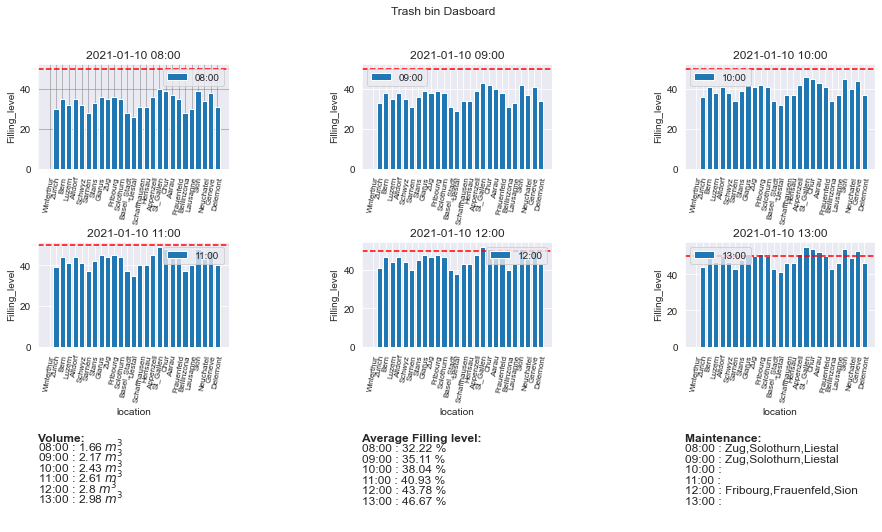

In [31]:
from mltools.stream_helper import Stream_Helper
Stream_Helper.stream_dashboard(pdf_window, mean_filling_level, volume, pdf_maintenance)

In [32]:
# stop the streaming query
streaming_query.stop()

## Trash bin optimal route

<img src="images/Context_4.jpg" alt="Context Diagram" width="800">

In [34]:
# instantiate Main TrashBin and Location_Map class 

trashbin = TrashBin()
map = Location_Map(trashbin.get_config('trash_bin'), location_data)

In [35]:
# Initialize Serverside data set   
# Establish a TCP connection and initialize the data set on the server.
    
client = TCP_Client(TCP_SERVER_HOST, TCP_SERVER_PORT, request_type = 'init') 
client.initialize(sensor_data_path)
client = None

Received from server: initialized


In [36]:
# Request Trash_bin sensor data from Server

client = TCP_Client(TCP_SERVER_HOST, TCP_SERVER_PORT, request_type = 'init') 
received_data = client.request_sensor_data()
client = None

In [37]:
# location_data.head()

,_c0,location,lat,lon,point
0,0,Winterthur,47.505637,8.724139,"(47.505637, 8.724139)"
1,1,Zurich,47.369501,8.538847,"(47.369501, 8.538847)"
2,2,Bern,46.948384,7.439946,"(46.948384, 7.439946)"
3,3,Luzern,47.055245,8.305225,"(47.055245, 8.305225)"
4,4,Altdorf,46.880884,8.643002,"(46.880884, 8.643002)"


In [38]:
# dist_matrix.head()

,_c0,location,Winterthur,Zurich,Bern,Luzern,Altdorf,Schwyz,Sarnen,Stans,...,St_Gallen,Chur,Aarau,Frauenfeld,Bellinzona,Lausanne,Sion,Neuchatel,Geneve,Delemont
0,0,Winterthur,0,25936,145050,84132,108369,93369,103589,99030,...,59341,160668,67903,17732,210965,248184,296670,172577,297884,138226
1,1,Zurich,25936,0,132930,51400,75636,60636,70856,66298,...,86002,118660,55783,44393,178233,236064,284550,160457,285764,126106
2,2,Bern,145050,132930,0,111962,152232,150998,131418,126859,...,205723,243011,83180,164115,252357,106377,154849,49972,156078,88432
3,3,Luzern,84132,51400,111962,0,42850,45856,22036,17478,...,144078,141183,63578,102469,142975,214595,263081,138988,264295,103680
4,4,Altdorf,108369,75636,152232,42850,0,19738,43890,27705,...,168592,134628,103448,126983,107025,254464,158543,178858,304165,143549


### Plot state of trash bins
The following plot shows the current state of the `filling level` as well as the `hardware failures`.

- blueish color:   no action required
- redish color:    filling level >= 50% nees to be considered
- yellowish color: harware failure - needs replacement

<Figure size 432x288 with 0 Axes>

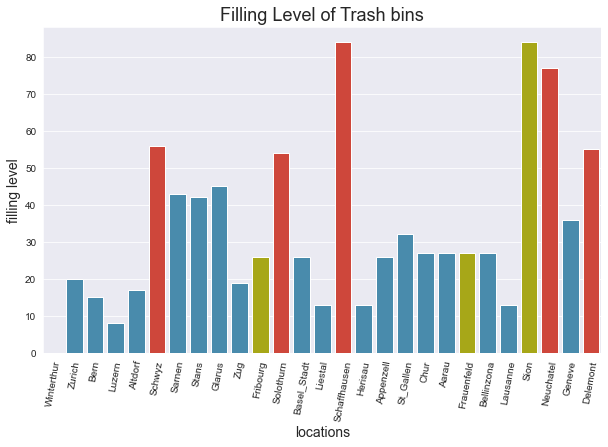

In [39]:
# visualize received sensor data in a barplot

sensor_data = trashbin.preprocess_sensor_data(received_data)
sns.set_style('darkgrid')
trashbin.plot_sensor_data_sns(sensor_data)

In [40]:
# Aggregate the trash bins which require attention into a list of nodes

# fill level >= 50%
sensors = np.where(sensor_data['filling_level'] >= 50)

# maintenance == True
maintenance = np.where(sensor_data['maintenance'] == True)
nodes = set(np.concatenate([sensors[0], maintenance[0]]))
nodes = list(nodes)  # convert to list again
print(nodes)

[5, 10, 11, 14, 20, 23, 24, 26]


### Solve the travelling salesman problem
Since we have now the nodes at hand which require attention, we are at the position to solve the `travelling salesman problem`.   
In order to resolve the travelling salesman problem we need a distance matrix, which contains the distances between every location.  
The TSP and Route_Analytics classes are the work horses, which evaluate the optimal way.  

The result of the optimal route is displayed as output.  
 
- Total distance in `[m]`
- ID of each location
- Location names

#### Distance matrix calculation 
The one thing we manually needed to define is the location of each trash bin. A trash bin location is defined by its `geospatial data` (coordinates longitude and latitude).  
For the distance matrix calculation and directions (latter on used), the following API's have been used:  

- [Googles Distance Matrix API](https://developers.google.com/maps/documentation/distance-matrix/overview)  
- [Googles Directions API](https://developers.google.com/maps/documentation/directions/overview)


In [41]:
tsp = TSP()
data, ref = tsp.create_data_model(dist_matrix, nodes, prod = True)

route_analytics = Route_Analytics()
manager, routing, solution = route_analytics.estimate_route(data)
route, route_distance = tsp.solution(manager, routing, solution)
route_tsp = route_analytics.ref_map(route, ref)

print('Route Distance: {} [m]'.format(route_distance))
print('Route IDs: {}'.format(route))
print('Location names: {}'.format(route_tsp))

Route Distance: 778330 [m]
Route IDs: [0, 5, 4, 1, 6, 2, 7, 8, 3, 0]
Location names: ['Winterthur', 'Frauenfeld', 'Schaffhausen', 'Schwyz', 'Sion', 'Fribourg', 'Neuchatel', 'Delemont', 'Solothurn', 'Winterthur']


## Visualization of optimal route
### Prepare markers and directions
Markers are location points, which the garbage man needs to approach. Markers come in two flavours "filling level" and "maintenance".   
The location of a trash bin will indicated with a marker, as soon as he exceeds the 50% filling level. Another marker is applied for   
maintenance reasons. Hardware tends to fail over time. Therefore, we also consider the hw maintenance flag, which needs to be considered   
as alocation point on a route. 

<img src="images/Context_5.jpg" alt="Context Diagram" width="800">

In [42]:
locations_tsp = route_tsp
location_markers_tsp = []

for location in route_tsp: 
    location_markers_tsp.append(map.location_point(location))

print(location_markers_tsp)

[(47.505637, 8.724139), (47.557165, 8.894863), (47.698682, 8.632284), (47.021109, 8.654043), (46.232315, 7.360869), (46.803191, 7.149124), (46.993842, 6.929066), (47.363905, 7.34596), (47.210102, 7.529706), (47.505637, 8.724139)]


In [43]:
fig = map.plot_base_map()

In [44]:
print(route_tsp)

# locations = [winterthur_point, zurich_point, bern_point]
fig = map.add_marker(fig, location_markers_tsp)

length = len(route_tsp)
for i, location in enumerate(location_markers_tsp):
    if i < (length - 1):
        fig = map.add_direction(fig, location, location_markers_tsp[i + 1])

fig

['Winterthur', 'Frauenfeld', 'Schaffhausen', 'Schwyz', 'Sion', 'Fribourg', 'Neuchatel', 'Delemont', 'Solothurn', 'Winterthur']


Figure(layout=FigureLayout(border='1px solid black', height='1100px', padding='1px', width='1600px'))

### Update sensor data
We assume, that after showing the trash bins have been emptied and maintenance on IoT hardware has taken place if required.   
At this point we need to tell the server the new situation, which means that the `filling level` must be reset to `0` and hardware failure has been resolved.   
So we inform the server by sending him the `changed sensor_data`.   

In [45]:
reference = sensor_data[['id', 'city']]
sensor_data = trashbin.update_sensor_data(received_data, route_tsp, reference)

In [46]:
# Update sensor data - send data to Server
# ------------------------------------------

client = TCP_Client(TCP_SERVER_HOST, TCP_SERVER_PORT, request_type = 'init') 
client.update_sensor_data(sensor_data)
client = None

Sensor data state: updated


In [47]:
# We will check now the new situation by
# requesting Trash_bin sensor data from Server

client = TCP_Client(TCP_SERVER_HOST, TCP_SERVER_PORT, request_type = 'init') 
received_data = client.request_sensor_data()
client = None

<Figure size 432x288 with 0 Axes>

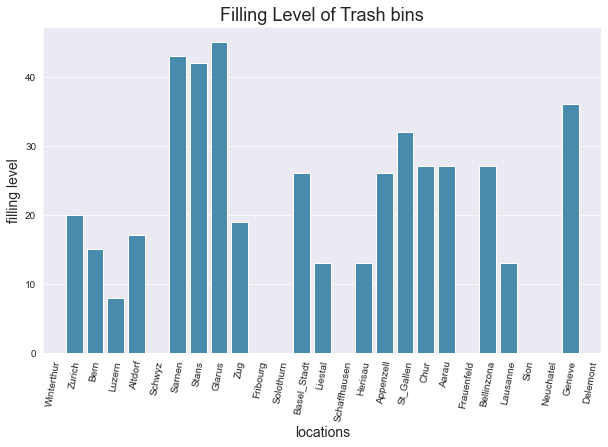

In [48]:
sensor_data = trashbin.preprocess_sensor_data(received_data)

sns.set_style('darkgrid')
trashbin.plot_sensor_data_sns(sensor_data)

## Assign random values
This is actually the optional part to simulate new filling levels. Random values will be applied to simulate a new route.

In [ ]:
# This step allows to simulate changes of trash bin filling levels 
# by randomly assign values

client = TCP_Client(TCP_SERVER_HOST, TCP_SERVER_PORT, request_type = 'random') 
received_data = client.assign_random_values()
client = None

## Conclusion
The final Big Data Project has been a challange overall. Since no streaming service exists, all data needed to be created syntetically.   
Creating synthetic data to simulate a data stream is tedious and time consuming. But creating the foundations for a `new Product` and   
finding out that it generally works, was a delight. There are now various additional aspects, which could be considered when continuing   
with the given project as follows:   

- Apply Machine learning to analyze historic data and predict the future
- Estimating the time consumption for a route considering the traffic by using further google API's  
- Consider the use of multiple routes and therefore additional Vehicles
- Prepare a decent interactive Web Front End 



